# Kmeans Clustering

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
#env variables
write_files = False
fit_model = False
model_path = "file:///home/work/data/kmeans_movies_model"

In [3]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'KMEANS Clustering')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-30 01:19:22,415 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in data

In [4]:
train_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_train/", inferSchema=True)
test_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_test/", inferSchema=True)
train_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Action: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)



In [5]:
col_names = train_df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
feat_cols = sorted(list(set(col_names).difference(set(exc_cols))))

### Form train and test features for k-means

In [6]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features', handleInvalid='skip')
train = assembler.transform(train_df)
test = assembler.transform(test_df)

### Fit k-means

In [7]:
cluster_list = list(range(10,1501,10))
kmeans_algo = KMeans(featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
evaluator = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')


grid = ParamGridBuilder().addGrid(kmeans_algo.k, cluster_list).build()

tvs = TrainValidationSplit(estimator=kmeans_algo, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=0)

if fit_model:
    start = time.time()
    tvsModel = tvs.fit(train)
    tot_runtime = time.time() - start
    print(f"Total runtime to fit k-means model: {tot_runtime}")
    
if write_files:
    tvsModel.write().save(model_path)

## Read in model

In [8]:
tvsModel = TrainValidationSplitModel.read().load(model_path)
train_score = evaluator.evaluate(tvsModel.transform(train))
test_score = evaluator.evaluate(tvsModel.transform(test))
print(f"Train score: {train_score} Test score: {test_score}")

2022-05-30 01:19:35,394 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Train score: 0.6355963350995041 Test score: 0.5725490613357676


K: 1350 cosine score: 0.6031929712453477


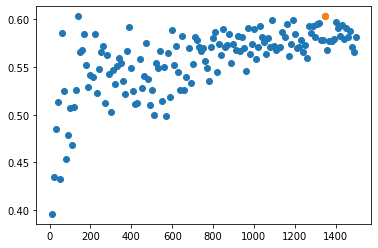

In [9]:
plt.scatter(cluster_list, tvsModel.validationMetrics)
k = tvsModel.bestModel.getK()
k_i = int((k /10) - 1)
plt.scatter(k, tvsModel.validationMetrics[k_i])
plt.savefig('../../data/kmeans_scatter.png')
print(f'K: {k} cosine score: {tvsModel.validationMetrics[k_i]}')

In [10]:
spark.stop()